Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [1]:
##!unzip -q "/content/drive/MyDrive/CNN_Assignment/CNN_assignment.zip" -d "/content/drive/MyDrive/CNN_Assignment/"

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Dropout

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_datasets as tfds

import itertools
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [5]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
#train_path = '/content/drive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
#test_path = '/content/drive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
train_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180
classes=['pigmented benign keratosis',
 'melanoma',
 'vascular lesion',
 'actinic keratosis',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'dermatofibroma',
 'nevus']
 
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(img_height,img_width), classes=classes, batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(img_height,img_width), classes=classes, batch_size=batch_size, shuffle=False)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

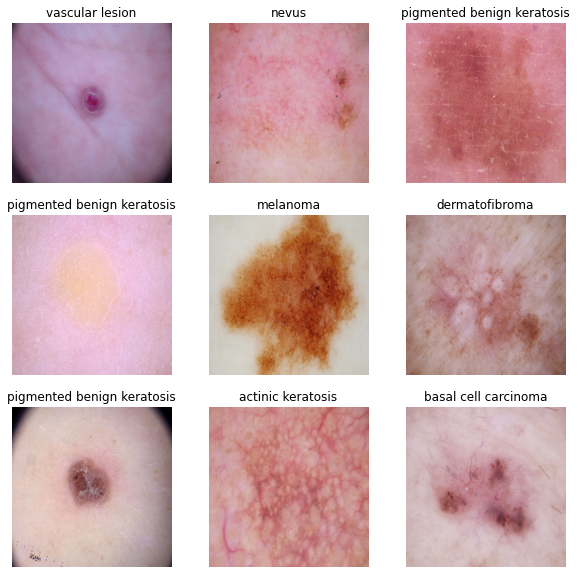

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
nclasses = 9

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nclasses)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
for btchimages, btchlabels in train_ds.take(1):
    model.build(input_shape=btchimages.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 178, 178, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 89, 89, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 87, 87, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 43, 43, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 41, 41, 32)          9

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 53s 891ms/step - loss: 2.0667 - accuracy: 0.2243 - val_loss: 1.9953 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 40s 718ms/step - loss: 1.8528 - accuracy: 0.3320 - val_loss: 1.7457 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 40s 723ms/step - loss: 1.6028 - accuracy: 0.4353 - val_loss: 1.5385 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 40s 714ms/step - loss: 1.4615 - accuracy: 0.4855 - val_loss: 1.4208 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 40s 712ms/step - loss: 1.3742 - accuracy: 0.5112 - val_loss: 1.5235 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 40s 723ms/step - loss: 1.2767 - accuracy: 0.5435 - val_loss: 1.4072 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 40s 719ms/step - loss: 1.2506 - accuracy: 0.5480 - val_loss: 1.4003 - val_accuracy: 0.5414

### Visualizing training results

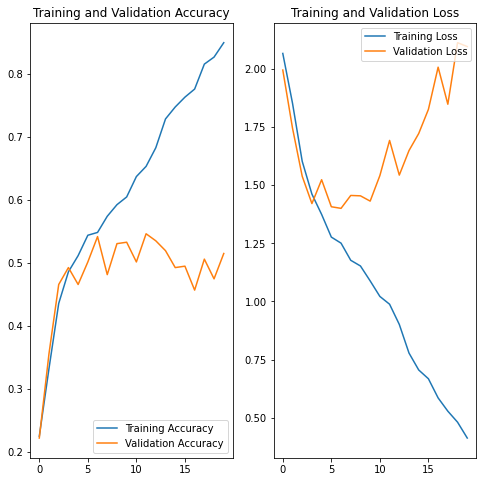

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

##### The accuracy of model is very less so we shall make the model more complex by adding more layers which can extract more features.
##### Also, the model is slightly overfitted, so we shall increase the dropout from 0.25 to 0.7

In [ ]:
#### Write your findings here

In [47]:
augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

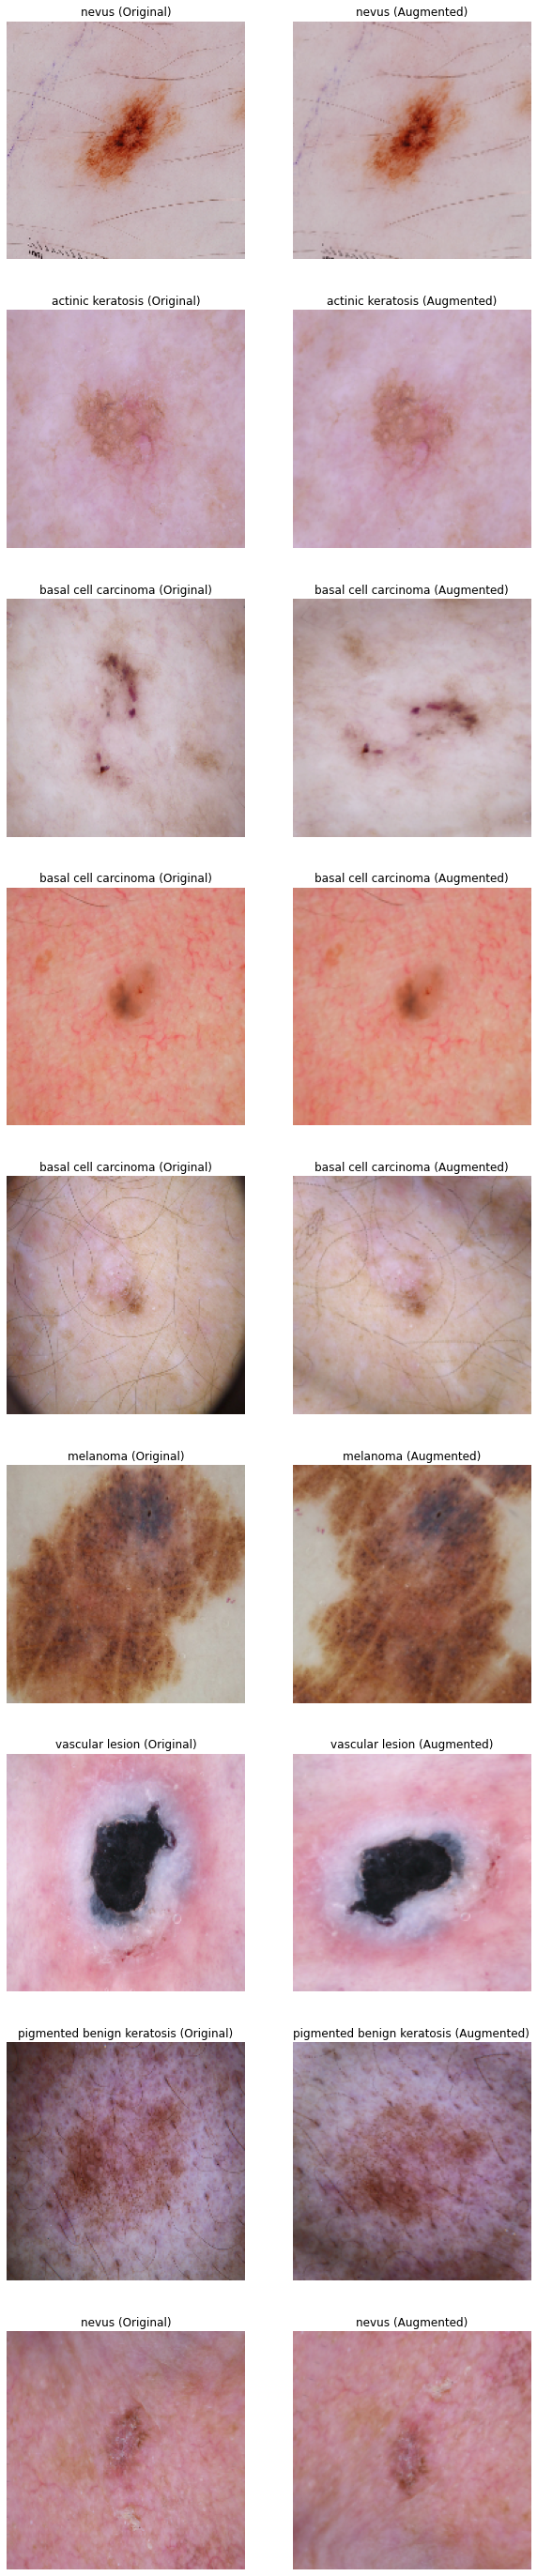

In [48]:
plt.figure(figsize = (10,50))
for images, labels in train_ds.take(1):
    augmented_images = augmentation(images)
    for i in range(9):
        plt.subplot(9,2,2*i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + ' (Original)')
        plt.axis("off")
        
        plt.subplot(9,2,2*i+2)
        plt.imshow(augmented_images[i])
        plt.title(class_names[labels[i]]+ ' (Augmented)')
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [56]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

new_model= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(units=9, activation= 'softmax')
])

### Compiling the model

In [57]:
## Your code goes here
new_model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy'])

### Training the model

In [58]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = new_model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=epochs,
    verbose=2
)

Epoch 1/20
70/70 - 122s - loss: 2.0560 - accuracy: 0.2041 - val_loss: 2.1755 - val_accuracy: 0.1356 - 122s/epoch - 2s/step
Epoch 2/20
70/70 - 111s - loss: 1.9991 - accuracy: 0.2193 - val_loss: 2.3497 - val_accuracy: 0.2458 - 111s/epoch - 2s/step
Epoch 3/20
70/70 - 110s - loss: 1.9302 - accuracy: 0.2657 - val_loss: 2.1036 - val_accuracy: 0.2712 - 110s/epoch - 2s/step
Epoch 4/20
70/70 - 109s - loss: 1.8597 - accuracy: 0.3211 - val_loss: 2.1282 - val_accuracy: 0.2966 - 109s/epoch - 2s/step
Epoch 5/20
70/70 - 110s - loss: 1.8269 - accuracy: 0.3234 - val_loss: 2.1582 - val_accuracy: 0.3305 - 110s/epoch - 2s/step
Epoch 6/20
70/70 - 109s - loss: 1.8169 - accuracy: 0.3318 - val_loss: 2.1742 - val_accuracy: 0.2966 - 109s/epoch - 2s/step
Epoch 7/20
70/70 - 110s - loss: 1.8025 - accuracy: 0.3403 - val_loss: 2.1248 - val_accuracy: 0.2966 - 110s/epoch - 2s/step
Epoch 8/20
70/70 - 120s - loss: 1.7505 - accuracy: 0.3738 - val_loss: 2.1539 - val_accuracy: 0.2797 - 120s/epoch - 2s/step
Epoch 9/20
70/70

### Visualizing the results

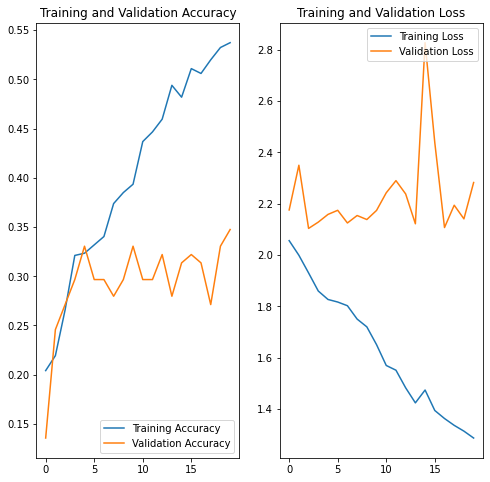

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

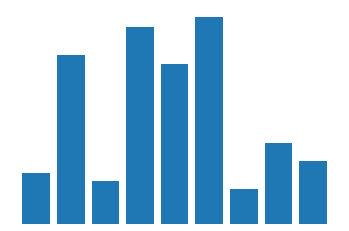

                        Class  ImageCount
5  pigmented benign keratosis         462
3                    melanoma         438
1        basal cell carcinoma         376
4                       nevus         357
7     squamous cell carcinoma         181
8             vascular lesion         139
0           actinic keratosis         114
2              dermatofibroma          95
6        seborrheic keratosis          77


In [60]:
class_freq = {}
for cls in class_names:
    class_freq[cls] = len(list(data_dir_train.glob(cls+'/*.jpg')))
plt.bar(range(len(class_freq)), class_freq.values(), tick_label=class_freq.keys())
plt.axis('off')
plt.show()
df = pd.DataFrame({
    'Class': class_freq.keys(),
    'ImageCount':class_freq.values()
})
print(df.sort_values(by='ImageCount',ascending=False))

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [61]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [62]:
path_list= [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [63]:
path_to_training_dataset='Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC84D2D5D50>: 100%|██████████| 500/500 [00:10<00:00, 48.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC85237C550>: 100%|██████████| 500/500 [00:10<00:00, 48.47 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC84CF4E290>: 100%|██████████| 500/500 [00:10<00:00, 49.55 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FC84CAE2F50>: 100%|██████████| 500/500 [00:56<00:00,  8.78 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FC84CFA1E10>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC84E52E890>: 100%|██████████| 500/500 [00:10<00:00, 48.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC84CFA0B50>: 100%|██████████| 500/500 [00:25<00:00, 19.54 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC84E933190>: 100%|██████████| 500/500 [00:11<00:00, 42.21 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC84CFA0590>: 100%|██████████| 500/500 [00:10<00:00, 47.08 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [64]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [65]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000152.jpg_0bef2c74-6b7e-49a5-be1f-f49ce32bc224.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000148.jpg_9e9efd48-339d-40fd-a489-ff168fb5b076.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000308.jpg_84ebbe28-4510-43a0-bf8b-db7c30b86b7b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010863.jpg_afcba0f8-6040-48c2-a4fd-08e0b81f1672.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010372.jpg_d610c5a3-202b-4b67-bb80-b98fa1d6f04c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010358.jpg_c100939f-792a-4b2d-9957-b6a99677e526.jpg',
 'Skin cancer IS

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [67]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [68]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [69]:
new_df['Label'].value_counts()

Train                         2239
melanoma                       500
pigmented benign keratosis     500
nevus                          500
basal cell carcinoma           500
actinic keratosis              500
squamous cell carcinoma        500
vascular lesion                500
seborrheic keratosis           500
dermatofibroma                 500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [70]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [71]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [73]:
## your code goes here
final_model= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(264, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(units=9, activation= 'softmax')
    
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [74]:
## your code goes here
final_model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [75]:
epochs = 30
## Your code goes here, use 50 epochs.
history = final_model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=epochs,
    verbose=2
)

Epoch 1/30
70/70 - 122s - loss: 2.0397 - accuracy: 0.1854 - val_loss: 2.2239 - val_accuracy: 0.1356 - 122s/epoch - 2s/step
Epoch 2/30
70/70 - 113s - loss: 2.0274 - accuracy: 0.1952 - val_loss: 2.3137 - val_accuracy: 0.1356 - 113s/epoch - 2s/step
Epoch 3/30
70/70 - 111s - loss: 1.9865 - accuracy: 0.2309 - val_loss: 2.2429 - val_accuracy: 0.2203 - 111s/epoch - 2s/step
Epoch 4/30
70/70 - 113s - loss: 1.8910 - accuracy: 0.3028 - val_loss: 2.1615 - val_accuracy: 0.3136 - 113s/epoch - 2s/step
Epoch 5/30
70/70 - 109s - loss: 1.8363 - accuracy: 0.3265 - val_loss: 2.1175 - val_accuracy: 0.2627 - 109s/epoch - 2s/step
Epoch 6/30
70/70 - 679s - loss: 1.8140 - accuracy: 0.3305 - val_loss: 2.2443 - val_accuracy: 0.3136 - 679s/epoch - 10s/step
Epoch 7/30
70/70 - 1831s - loss: 1.8184 - accuracy: 0.3292 - val_loss: 2.1988 - val_accuracy: 0.3559 - 1831s/epoch - 26s/step
Epoch 8/30
70/70 - 1405s - loss: 1.8020 - accuracy: 0.3274 - val_loss: 2.0773 - val_accuracy: 0.2542 - 1405s/epoch - 20s/step
Epoch 9/3

#### **Todo:**  Visualize the model results

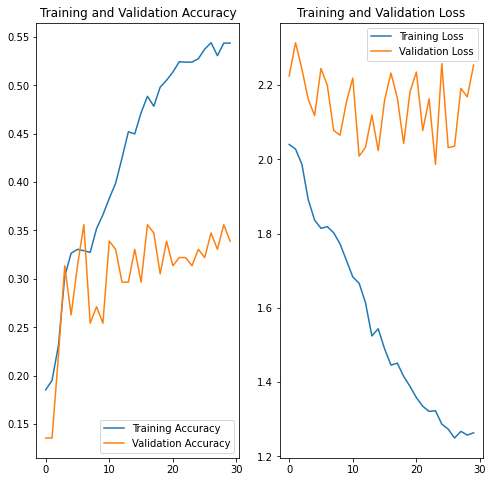

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We still have a overfitting model but we have much better accuracy than previous models.At end we have around 10% accuuracy difference between training and validation data. Class rebalance helped us in getting better accuracy.

We can reduce the  odel or add a data augmentation layer before it.